In [69]:
    from google.colab import drive
    drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [71]:
cd UOC/comp vision/

/content/drive/MyDrive/UOC/comp vision


In [72]:
cd styles/

/content/drive/MyDrive/UOC/comp vision/styles


In [74]:
ls

cubism.webp       pic2.webp  pic5.jpg   pic8.webp   stylized_output.jpg
pic1.jpeg         pic3.jpg   pic6.jpg   pic9.jpg
pic2convert.jpeg  pic4.png   pic7.jpeg  picart.jpg


In [75]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    return np.clip(x / 255.0, 0, 1)

def gram_matrix(tensor):
    x = tf.transpose(tensor, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

content_path = 'picart.jpg'
style_path = 'cubism.webp'

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)
generated_image = tf.Variable(content_image, dtype=tf.float32)

In [76]:

#vgg
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

#feature extraction
outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
model = Model(inputs=vgg.input, outputs=outputs)
model.trainable = False

#loss func
def compute_loss(generated, style, content):
    generated_outputs = model(generated)
    style_outputs = model(style)
    content_outputs = model(content)

    # Style loss
    style_loss = 0
    for gen, sty in zip(generated_outputs[:5], style_outputs[:5]):
        gram_gen = gram_matrix(gen[0])
        gram_style = gram_matrix(sty[0])
        style_loss += tf.reduce_mean(tf.square(gram_gen - gram_style))

    # Content loss
    content_loss = tf.reduce_mean(tf.square(generated_outputs[5][0] - content_outputs[5][0]))

    total_loss = 1e-2 * style_loss + content_loss
    return total_loss


In [ ]:
opt = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, style_image, content_image)
    grad = tape.gradient(loss, generated_image)
    opt.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, -128.0, 128.0))


epochs = 500
for i in range(epochs):
    train_step()
    print(f"Iteration {i} completed")


Iteration 0 completed
Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Iteration 4 completed
Iteration 5 completed
Iteration 6 completed
Iteration 7 completed
Iteration 8 completed
Iteration 9 completed
Iteration 10 completed
Iteration 11 completed
Iteration 12 completed
Iteration 13 completed
Iteration 14 completed
Iteration 15 completed
Iteration 16 completed
Iteration 17 completed
Iteration 18 completed
Iteration 19 completed
Iteration 20 completed
Iteration 21 completed
Iteration 22 completed
Iteration 23 completed
Iteration 24 completed
Iteration 25 completed
Iteration 26 completed
Iteration 27 completed
Iteration 28 completed
Iteration 29 completed
Iteration 30 completed
Iteration 31 completed
Iteration 32 completed
Iteration 33 completed
Iteration 34 completed
Iteration 35 completed
Iteration 36 completed
Iteration 37 completed
Iteration 38 completed
Iteration 39 completed
Iteration 40 completed
Iteration 41 completed
Iteration 42 completed
Iteration 43 complete

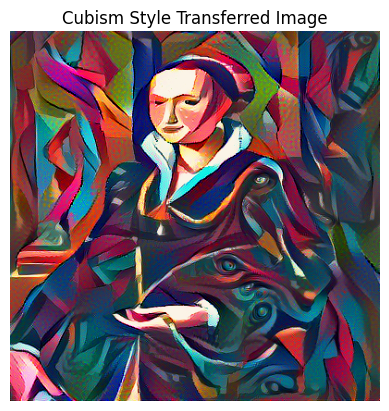

In [85]:

output = deprocess_image(generated_image.numpy())
plt.imshow(output)
plt.axis('off')
plt.title('Cubism Style Transferred Image')
plt.show()


In [ ]:
pip install lpips


In [82]:
import lpips
import torch
import torchvision.transforms as T
from PIL import Image

# Load LPIPS model (AlexNet is default, you can use 'vgg' or 'squeeze' too)
lpips_model = lpips.LPIPS(net='alex').to(device)

def load_lpips_image(img_path):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # LPIPS expects [-1, 1]
    ])
    img = Image.open(img_path).convert('RGB')
    return transform(img).unsqueeze(0).to(device)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [83]:
content = load_lpips_image("picart.jpg")
style = load_lpips_image("cubism.webp")
stylized = load_lpips_image("stylized_output.jpg")

# LPIPS scores
score_content = lpips_model(content, stylized)
score_style = lpips_model(style, stylized)

print(f"LPIPS(Content vs Stylized): {score_content.item():.4f}")
print(f"LPIPS(Style vs Stylized):   {score_style.item():.4f}")


LPIPS(Content vs Stylized): 0.8092
LPIPS(Style vs Stylized):   0.9684


In [84]:
content

tensor([[[[-0.5216, -0.5137, -0.4824,  ..., -0.5843, -0.5843, -0.5843],
          [-0.5451, -0.5373, -0.5137,  ..., -0.5843, -0.5843, -0.5843],
          [-0.5529, -0.5529, -0.5294,  ..., -0.5843, -0.5843, -0.5843],
          ...,
          [-0.5451, -0.3412, -0.2392,  ..., -0.6000, -0.6078, -0.6235],
          [-0.5608, -0.2706, -0.1216,  ..., -0.6000, -0.6000, -0.6157],
          [-0.5216, -0.2392, -0.0588,  ..., -0.6000, -0.6000, -0.6078]],

         [[-0.6235, -0.6157, -0.5843,  ..., -0.6627, -0.6627, -0.6627],
          [-0.6471, -0.6392, -0.6157,  ..., -0.6627, -0.6627, -0.6627],
          [-0.6549, -0.6549, -0.6314,  ..., -0.6627, -0.6627, -0.6627],
          ...,
          [-0.6078, -0.4353, -0.3725,  ..., -0.6784, -0.6863, -0.7020],
          [-0.6000, -0.3490, -0.2471,  ..., -0.6784, -0.6784, -0.6941],
          [-0.5373, -0.2863, -0.1529,  ..., -0.6784, -0.6784, -0.6863]],

         [[-0.6863, -0.6784, -0.6471,  ..., -0.6784, -0.6784, -0.6784],
          [-0.7098, -0.7020, -